## Import section

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

## Read data

In [2]:
# пользовательские действия

user_actions = pd.read_parquet('data/user_actions_august.parquet')
user_actions.head()

,clientid,itemid,action_type,timestamp
0,179153,135391270,view,2019-08-06 15:14:45
1,179153,135391272,view,2019-08-06 15:16:29
2,179153,135391270,view,2019-08-08 09:07:29
3,179153,142132354,view,2019-08-20 17:59:58
4,179153,140487634,view,2019-08-23 16:46:39


In [3]:
user_actions['clientid'] = user_actions['clientid'].astype('uint32')
user_actions['itemid'] = user_actions['itemid'].astype('uint32')
user_actions['action_type'] = user_actions['action_type'].map({'view': 0, 'to_cart': 1}).astype('bool')
user_actions['timestamp'] = user_actions['timestamp'].dt.date.apply(dt.datetime.toordinal).astype('uint32')

user_actions.head()

,clientid,itemid,action_type,timestamp
0,179153,135391270,False,737277
1,179153,135391272,False,737277
2,179153,135391270,False,737279
3,179153,142132354,False,737291
4,179153,140487634,False,737294


In [4]:
user_actions['action_type'].value_counts()

False    48845454
True      8739766
Name: action_type, dtype: int64

In [5]:
user_actions.clientid.nunique()

1062707

In [4]:
# target данные для обучения

train_target = pd.read_csv('data/target_train.csv')
train_target.head()

,clientid,itemid,jointitemid,label,timestamp
0,7833842,31499843,138176581,1,2019-09-07 20:11:01
1,19548158,147389610,148381589,0,2019-08-31 22:32:31
2,32943407,6261257,4490956,0,2019-09-06 15:19:30
3,10185243,148455169,148455173,0,2019-09-03 17:43:50
4,30552232,152440009,152440052,0,2019-09-01 07:07:59


In [5]:
train_target['clientid'] = train_target['clientid'].astype('uint32')
train_target['itemid'] = train_target['itemid'].astype('uint32')
train_target['jointitemid'] = train_target['jointitemid'].astype('uint32')
train_target['label'] = train_target['label'].astype('int8')
train_target = train_target.drop(columns=['timestamp'])

train_target.head()

,clientid,itemid,jointitemid,label
0,7833842,31499843,138176581,1
1,19548158,147389610,148381589,0
2,32943407,6261257,4490956,0
3,10185243,148455169,148455173,0
4,30552232,152440009,152440052,0


## Generate some simple features

In [6]:
def calculate_popularity(user_actions, action_type):
    all_items = user_actions['itemid'].unique()
    
    tag = False
    if action_type == 'to_cart':
        tag = True
        
    ids, cnts = np.unique(
        user_actions[user_actions['action_type'] == tag]['itemid'].values,
        return_counts=True
    )
        
    res = pd.DataFrame(all_items.reshape(-1,1), columns=['itemid'])
    cnts_df = pd.DataFrame(np.vstack([ids, cnts]).T, columns=['itemid', f'{action_type}_cnt'])
    
    return res.merge(cnts_df, on='itemid', how='left').fillna(0)

def calculate_last_day_popularity(user_actions, action_type):
    max_day = user_actions['timestamp'].max()
    all_items = user_actions['itemid'].unique()

    tag = False
    if action_type == 'to_cart':
        tag = True
       
    condition = (
        (user_actions['action_type'] == tag) & 
        (user_actions['timestamp'] == max_day)
    )
    
    ids, cnts = np.unique(
        user_actions[condition]['itemid'].values,
        return_counts=True
    )    
    
    res = pd.DataFrame(all_items.reshape(-1,1), columns=['itemid'])
    cnts_df = pd.DataFrame(np.vstack([ids, cnts]).T, columns=['itemid', f'{action_type}_cnt_last_day'])
    
    return res.merge(cnts_df, on='itemid', how='left').fillna(0)

def calculate_day_avg_popularity(user_actions, action_type):
    all_items = user_actions['itemid'].unique()

    tag = False
    if action_type == 'to_cart':
        tag = True
       
    condition = (user_actions['action_type'] == tag)
    
    cnts_df = (
        user_actions[condition]
        .groupby(['itemid', 'timestamp'])['clientid']
        .agg(['count'])
        .reset_index()
        .drop(columns=['timestamp'])
        .rename(columns={'count': f'{action_type}_day_avg_cnt'})
    )    
    
    res = pd.DataFrame(all_items.reshape(-1,1), columns=['itemid'])
    
    return res.merge(cnts_df, on='itemid', how='left').fillna(0)
    
def generate_popularity_features(user_actions, target):
    view_cnts_df = calculate_popularity(user_actions, 'view').rename(columns={'itemid': 'jointitemid'})
    cart_cnts_df = calculate_popularity(user_actions, 'to_cart').rename(columns={'itemid': 'jointitemid'})
    
    res = target.copy()
    res = (
        res
        .merge(view_cnts_df, on='jointitemid', how='left')
        .fillna(0)
        .merge(cart_cnts_df, on='jointitemid', how='left')
        .fillna(0)
    )
    
    res['ctr'] = res['to_cart_cnt'] / (res['view_cnt'] + 1.)
    
    view_cnts_last_day_df = (
        calculate_last_day_popularity(user_actions, 'view')
        .rename(columns={'itemid': 'jointitemid'})
    )
    cart_cnts_last_day_df = (
        calculate_last_day_popularity(user_actions, 'to_cart')
        .rename(columns={'itemid': 'jointitemid'})
    )
    
    res = (
        res
        .merge(view_cnts_last_day_df, on='jointitemid', how='left')
        .fillna(0)
        .merge(cart_cnts_last_day_df, on='jointitemid', how='left')
        .fillna(0)
    )
    
    return res

In [7]:
train = generate_popularity_features(user_actions, train_target)
train.head()

,clientid,itemid,jointitemid,label,view_cnt,to_cart_cnt,ctr,view_cnt_last_day,to_cart_cnt_last_day
0,7833842,31499843,138176581,1,31.0,9.0,0.281250,0.0,0.0
1,19548158,147389610,148381589,0,24.0,9.0,0.360000,0.0,0.0
2,32943407,6261257,4490956,0,0.0,1.0,1.000000,0.0,0.0
3,10185243,148455169,148455173,0,10.0,1.0,0.090909,0.0,0.0
4,30552232,152440009,152440052,0,9.0,1.0,0.100000,0.0,0.0


## train model

In [8]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [9]:
X = train[['view_cnt', 'to_cart_cnt', 'ctr', 'view_cnt_last_day', 'to_cart_cnt_last_day']]
y = train['label']
X.head()

,view_cnt,to_cart_cnt,ctr,view_cnt_last_day,to_cart_cnt_last_day
0,31.0,9.0,0.281250,0.0,0.0
1,24.0,9.0,0.360000,0.0,0.0
2,0.0,1.0,1.000000,0.0,0.0
3,10.0,1.0,0.090909,0.0,0.0
4,9.0,1.0,0.100000,0.0,0.0


In [10]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features=2,
    random_state=7,
    class_weight={0: 1., 1: 1.},
    n_jobs=-1
)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 1.0},
                       criterion='gini', max_depth=5, max_features=2,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=7, verbose=0, warm_start=False)

## evaluate model

In [11]:
test_target = pd.read_csv('data/target_test.csv')
test_target.head()

,clientid,itemid,jointitemid,label,timestamp
0,8081929,152898248,152875664,0,2019-09-06 18:57:23
1,33378638,144847078,140715321,0,2019-09-02 07:09:31
2,36237195,149717596,149390783,0,2019-09-01 07:14:01
3,4190203,141835810,147130456,0,2019-09-06 07:18:33
4,35362099,24560937,155457711,0,2019-09-05 17:16:28


In [12]:
test_target['clientid'] = test_target['clientid'].astype('uint32')
test_target['itemid'] = test_target['itemid'].astype('uint32')
test_target['jointitemid'] = test_target['jointitemid'].astype('uint32')
test_target['label'] = test_target['label'].astype('int8')
test_target = test_target.drop(columns=['timestamp'])

test_target.head()

,clientid,itemid,jointitemid,label
0,8081929,152898248,152875664,0
1,33378638,144847078,140715321,0
2,36237195,149717596,149390783,0
3,4190203,141835810,147130456,0
4,35362099,24560937,155457711,0


In [13]:
test = generate_popularity_features(user_actions, test_target)
X_test = test[['view_cnt', 'to_cart_cnt', 'ctr', 'view_cnt_last_day', 'to_cart_cnt_last_day']]
y_test = test['label']

y_pred = model.predict_proba(X_test)[:, 1]

In [14]:
print ('roc_auc:', roc_auc_score(y_test.values, y_pred))

roc_auc: 0.5533934152733533


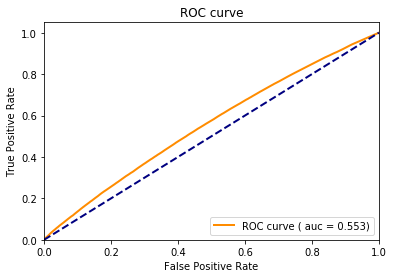

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
y_score = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
auc = round(roc_auc_score(y_test, y_score), 4)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC_AUC curve ( auc = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

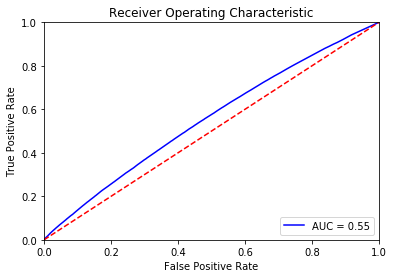

In [21]:
%matplotlib inline
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
print ('feature importances')
pd.DataFrame(model.feature_importances_.reshape(-1, 1), index=X.columns)

feature importances


,0
view_cnt,0.505370
to_cart_cnt,0.139702
ctr,0.085534
view_cnt_last_day,0.238827
to_cart_cnt_last_day,0.030567


In [16]:
test['prob'] = y_pred
test.head()

,clientid,itemid,jointitemid,label,view_cnt,to_cart_cnt,ctr,view_cnt_last_day,to_cart_cnt_last_day,prob
0,8081929,152898248,152875664,0,10.0,2.0,0.181818,0.0,0.0,0.113882
1,33378638,144847078,140715321,0,211.0,19.0,0.089623,11.0,1.0,0.156768
2,36237195,149717596,149390783,0,282.0,20.0,0.070671,5.0,1.0,0.155811
3,4190203,141835810,147130456,0,892.0,210.0,0.235162,14.0,2.0,0.153404
4,35362099,24560937,155457711,0,0.0,2.0,2.000000,0.0,0.0,0.107835


In [17]:
def recall_at_k(test, k):
    pred = (
        test
        .sort_values(['clientid', 'itemid', 'prob'], ascending=[True, True, False])
        .groupby(['clientid', 'itemid'])['jointitemid']
        .agg(list)
        .reset_index()
    )
    
    true = (
        test[test['label'] == 1]
        .groupby(['clientid', 'itemid'])['jointitemid']
        .agg(list)
        .reset_index()
    )
    
    pred_true_df = pred.merge(true, on=['clientid', 'itemid'], how='inner', suffixes=('_pred', '_true'))
    
    hits = 0
    alls = 0
    for pred, true in pred_true_df[['jointitemid_pred', 'jointitemid_true']].values:
        for idx in set(pred[:k]):
            if idx in set(true):
                hits += 1
        alls += len(set(true))

    return (hits * 1.) / alls

def mapk(test, k):   
    pred = (
        test
        .sort_values(['clientid', 'itemid', 'prob'], ascending=[True, True, False])
        .groupby(['clientid', 'itemid'])['jointitemid']
        .agg(list)
        .reset_index()
    )
    
    true = (
        test[test['label'] == 1]
        .groupby(['clientid', 'itemid'])['jointitemid']
        .agg(list)
        .reset_index()
    )
    
    pred_true_df = pred.merge(true, on=['clientid', 'itemid'], how='inner', suffixes=('_pred', '_true'))
    
    score = 0
    hits=0
    general_score=[]

    for pred, true in pred_true_df[['jointitemid_pred', 'jointitemid_true']].values:
        for i,dx in enumerate(set(pred[:k])):
            if dx in set(true):
                hits += 1
                score += hits/(i+1)
        general_score.append(score/k)
        score=0
        hits=0
    return np.mean(general_score)

In [18]:
print ('recall@k:', recall_at_k(test, 3))

recall@k: 0.4710243548366191


In [19]:
recall_at_k(test, 1)

0.18098274811732837

In [19]:
print ('map@k:', mapk(test, 3))

map@k: 0.11873534377036479


In [21]:
mapk(test, 1)

0.2149443512261203

In [22]:
test_ = test.copy()
test_['prob'] = test_['view_cnt']

In [23]:
recall_at_k(test_, 3)

0.46949488665085354

In [24]:
recall_at_k(test_, 1)

0.17820896683127893